# Television Network Analysis

## Jon Dickerson
##### Mentored by: Luca Belli

#### Network Centrality Measures


In the main document, I already briefly touched on the idea of _degree_, which is how many edges are connected to a given node. Since we've taken care of the plotting, we can expand our graph to include more shows. (This will increase processing time/resource requirements, so be careful if you don't have many resources.)

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from itertools import combinations
from collections import Counter
from collections import defaultdict

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Load Data
main_data = pd.read_csv('../data/mainData.csv')

# get top shows
show_ratings = main_data.groupby('title')['rank'].mean()
top_1000 = list(show_ratings.sort_values(ascending=False).head(1000).index)


# group by writer
grouped = main_data[main_data.title.isin(top_1000)].groupby(['name'])

output = []

# For ever writer, take all the combinations of show they've written for
# And deduplicate it using set()
for name, data in grouped:
    output.extend(set([x for x in combinations(data['title'],2) 
                           if x[0] != x[1]]))     # Can't match yourself

# Run a counter to help with weights later
output.sort()
c = Counter(output)

# loop through and get weights
graph_builder = []
for x in c:
    graph_builder.append((x[0], x[1], {'weight': c[x]}))
    
    
# Create graph
G = nx.Graph()

# Add edges (and thus nodes) from the graph_builder
G.add_edges_from(graph_builder)

# Add disconnected shows
for x in top_1000:
    if x not in G.nodes():
        G.add_node(x)

We can plot the graph, though we'll not expect to get much out of it given the larger number of shows.

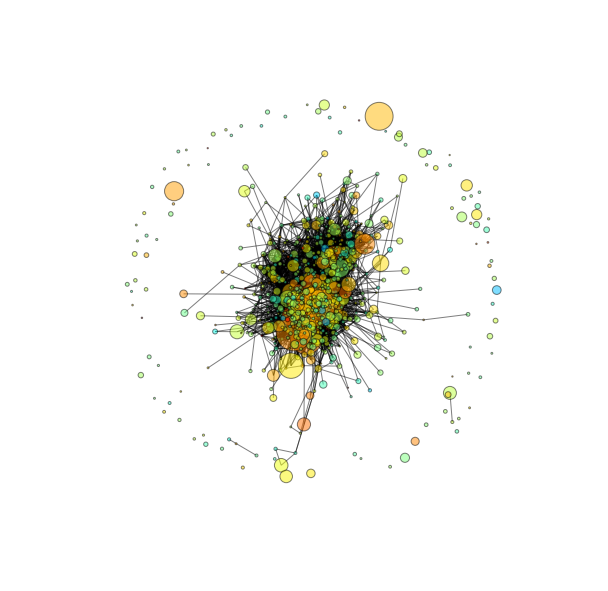

In [5]:
node_list = defaultdict(str)

top_10 = top_1000[:10]
shows = main_data[main_data.title.isin(top_1000)].groupby('title')

for x in [show[0] for show in shows]:
    if x in top_10:
        node_list[x] = x
    else:
        node_list[x] = ''
        
plt.figure(figsize=(10, 10))

pos=nx.spring_layout(G, k=0.15)

nx.draw_networkx(G, 
                 pos, 
                 alpha=0.5,
                 nodelist=node_list.keys(),
                 node_size = [show[1]['votes'].mean()/10 for show in shows],
                 node_color = [show[1]['rating'].mean()/10 for show in shows], 
                 with_labels=False)
# nx.draw_networkx_labels(G, pos, labels=node_list)  can uncomment for lables (they're ugly)
plt.axis('off')
plt.show()

We can look at the highest degree shows, in this context, that would be the shows with the most successful writer's rooms, that is, shows whose writers have gone on to make other shows most often.

In [6]:
degree = pd.DataFrame.from_dict(G.degree(), 
                                orient='index').reset_index()
degree.columns = ['title', 'degree']
degree.sort_values(by='degree', ascending=False).head()

,title,degree
900,Law & Order: Special Victims Unit,154
335,Crossing Jordan,126
343,The X Files,123
643,Charmed,121
593,Smallville,118


"Law & Order" should be no surprise, incredibly long running, many writers have come and gone. The others on this list also have longevity on their side.

What about the opposite? What kind of shows have no connections?

In [7]:
degree_with_rank = degree.merge(pd.DataFrame(show_ratings).reset_index())
degree_with_rank[degree_with_rank.degree == 0].sort_values('rank', ascending=False).head()

,title,degree,rank
592,Penny Dreadful,0,6.981619
860,Downton Abbey,0,6.963128
616,American Crime Story,0,6.952101
151,Hillbilly Horror Show,0,6.948488
100,The Fall,0,6.935233


In [8]:
degree_with_rank[degree_with_rank.degree == 0]['rank'].mean() - show_ratings.mean()

0.0020272397445406654

This is interesting. The rank number is a very compressed metric, but the average show that has no other connections is higher than the average show in general. This potentially means that shows that are from unknown writers tend to be better, since there isn't a long track record of performance for the staff. 

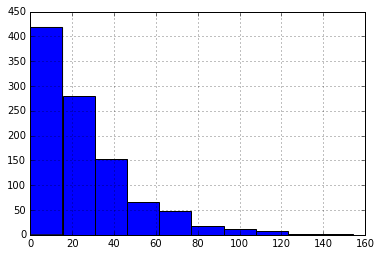

In [9]:
degree_with_rank.degree.hist()

The distribution of degree is interesting as well, seeming to follow n exponential or maybe poisson distribution, with "Law & Order" a potential outlier. The average degree is 24, but the median is only 19, evidenced in the right-skewed graph.

In [10]:
nx.average_clustering(G)

0.2811258992875921

The clustering coefficient is the tendency of the graph to "close loops" or "connect", in other words, if a node connects to two other nodes, what is the probability the other nodes also connect. It makes sense that it is fairly low, since we limited our shows in time, so that the number of shows that can be worked on by one writer concurrently is relatively small.

#### Conclusion

There are many network centrality measures that could be applicable and interesting here, but I just wanted to touch on two of the most common. The [networkx](http://networkx.readthedocs.org/en/networkx-1.11/index.html) package has plenty more if you'd like to fork this repo and play around on your own.